In [1]:
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<img src="https://i.imgur.com/UtPBG1L.png">

<h3>Quickdraw Dataset</h3>
<p><a href="https://ai.googleblog.com/2017/04/teaching-machines-to-draw.html">Google Blog</a></p>
<p>https://console.cloud.google.com/storage/browser/quickdraw_dataset/sketchrnn?pli=1</p>

In [4]:
def filter_by_length(data, 
                     min_length=-float('inf'), 
                     max_length= float('inf')):
    return [stroke for stroke in data if stroke.shape[0] <= max_length and stroke.shape[0] >= min_length]

def remove_gaps(data):
    strokes = []
    for stroke in data:
        stroke = np.minimum(stroke,  1000)
        stroke = np.maximum(stroke, -1000)
        strokes.append(stroke)
    return strokes

def scale(data):
    scale = np.std(np.concatenate([np.delete(x, -1, axis=1).ravel() for x in data]))
    strokes = []
    for stroke in data:
        stroke[:,0:2] = stroke[:,0:2] / scale
        strokes.append(stroke)
    return strokes

class Dataset:
    def __init__(self, 
                 path, 
                 min_length=-float('inf'), 
                 max_length=float('inf')):
        
        dataset   = np.load(path, encoding='latin1')
        data      = dataset['train']
        data      = [np.float32(x) for x in data]
        data      = filter_by_length(data, min_length, max_length)
        data      = remove_gaps(data)
        data      = scale(data)
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def get_batch(self, batch_size):
        random_ids = np.random.randint(0, len(self), batch_size)
        batch      = [self.data[idx] for idx in random_ids]
        strokes    = []
        lengths    = []
        max_size   = max(map(lambda x: x.shape[0], batch))

        for stroke in batch:
            length     = stroke.shape[0]
            new_stroke = np.zeros((max_size, 5))
            new_stroke[:length,      :2]  = stroke[:, :2]
            new_stroke[:length - 1,   2]  = 1 - stroke[:-1, 2]
            new_stroke[:length,       3]  = stroke[:, 2]
            new_stroke[length-1:,     4]  = 1
            new_stroke[length-1,    2:4]  = 0
            lengths.append(stroke.shape[0])
            strokes.append(new_stroke)
            
        mask = torch.zeros(batch_size, max_size + 1)
        for idx, length in enumerate(lengths):
            mask[idx, :length] = 1
            
        batch    = np.stack(strokes)

        batch    = torch.FloatTensor(batch)
        sos      = torch.FloatTensor([[0, 0, 1, 0, 0] for _ in range(batch_size)]).unsqueeze(1)
        eos      = torch.FloatTensor([[0, 0, 0, 0, 1] for _ in range(batch_size)]).unsqueeze(1)
        batch_in  = torch.cat([sos, batch], 1)
        batch_out = torch.cat([batch, eos], 1)
        
        return batch, batch_in, batch_out, mask

In [16]:
batch_size = 32
data_path  = 'Datasets/bicycle.full.npz'
data = Dataset(data_path)

In [17]:
batch, batch_in, batch_out, mask = data.get_batch(batch_size)

In [18]:
batch = batch.cuda()
batch_in = batch_in.cuda()
batch_out = batch_out.cuda()
mask = mask.cuda()

<h2>Модель</h2>

<img src="https://i.imgur.com/VRYIHha.png">

In [32]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, z_size):
        super(Encoder, self).__init__()
        
        self.lstm = nn.LSTM(5, hidden_size, batch_first = True, bidirectional = True)
        self.linear_mean = nn.Linear(2 * hidden_size, z_size)
        self.linear_std = nn.Linear(2 * hidden_size, z_size)
        self.linear_weight = nn.Linear(hidden_size, z_size)
        
    def forward(self, x):
        '''
        Inputs:
            x: (batch x seq_len x 5)
        Outputs:
            z:    (batch x z_size)
            mean: (batch x z_size)
            std:  (batch x z_size)
        '''
        batch_size = x.size(0)
        _, (hidden, cell) = self.lstm(x)
        
        hidden = hidden.transpose(0, 1)

        hidden = hidden.contiguous().view(batch_size, -1)

 
        mean = self.linear_mean(hidden)
        std  = self.linear_std(hidden)
        
        std = (std / 2).exp()
        
        z = mean + std * torch.randn(batch_size, 1).cuda()
        
        return z, mean, std
        
        
class Decoder(nn.Module):
    def __init__(self, z_size, hidden_size, num_gaussians):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_gaussians = num_gaussians
        
        self.linear_z = nn.Linear(z_size, 2 * hidden_size)
        self.lstm = nn.LSTM(5 + z_size, hidden_size, batch_first = True)
        
        self.linear_weight = nn.Linear(hidden_size, num_gaussians)
        self.linear_mean_x = nn.Linear(hidden_size, num_gaussians)
        self.linear_mean_y = nn.Linear(hidden_size, num_gaussians)
        self.linear_std_x = nn.Linear(hidden_size, num_gaussians)
        self.linear_std_y = nn.Linear(hidden_size, num_gaussians)
        self.linear_rho_xy = nn.Linear(hidden_size, num_gaussians)
        self.linear_pen = nn.Linear(hidden_size, 3)
        
    def forward(self, x, z, hidden_cell=None, generate=False):
        '''
        Inputs:
            x: (batch x seq_len x z_size + 5)
            z: (batch x seq_len x z_size)
            hidden_cell: [(1 x batch x hidden), (1 x batch x hidden)]
            generate: bool
        Outputs:
            weight: (batch x seq_len x num_gaussians)
            mean_x: (batch x seq_len x num_gaussians)
            mean_y: (batch x seq_len x num_gaussians)
            std_x:  (batch x seq_len x num_gaussians)
            std_y:  (batch x seq_len x num_gaussians)
            rho_xy: (batch x seq_len x num_gaussians) 
            pen: (batch x seq_len x 3)
            hidden_cell: [(1 x batch x hidden), (1 x batch x hidden)]
        '''
        if hidden_cell is None:
            hidden_cell = self.linear_z(z)
            hidden_cell = torch.tanh(hidden_cell)

            hidden_state, cell = torch.chunk(hidden_cell, 2, dim=1)
            hidden_state, cell = hidden_state.unsqueeze(0).contiguous(), cell.unsqueeze(0).contiguous()

            
        else: 
            hidden_state, cell = hidden_cell

        outputs, (hidden_state, cell) = self.lstm(x, (hidden_state, cell))
        
        if generate:
            outputs = hidden
            
        
        weight = self.linear_weight(outputs) 
        mean_x = self.linear_mean_x(outputs) 
        mean_y = self.linear_mean_y(outputs) 
        std_x = self.linear_std_x(outputs) 
        std_y = self.linear_std_y(outputs) 
        rho_xy =  self.linear_rho_xy(outputs) 
        pen = self.linear_pen(outputs)
        
        weight = F.softmax(weight, dim = -1)
        std_x = std_x.exp()
        std_y = std_y.exp()
        rho_xy = torch.tanh(rho_xy)
        pen = F.softmax(pen, dim = -1)
        
        return weight, mean_x, mean_y, std_x, std_y, rho_xy, pen, (hidden_state, cell)

<h3>Kullback Leibler Loss</h3>

In [33]:
def compute_kl_loss(mean, std, kl_min=0.2, eta_min=0.01):
    eta_step = 1 - (1 - eta_min) * 0.99995

    kl   = -0.5 * (1 + std - mean.pow(2) - std.exp()).mean()
    loss = 0.5 * eta_step * torch.max(kl, torch.tensor(kl_min).to(mean.device))
    return loss

<h3>Bivariate Normal Distribution</h3>

In [34]:
def pdf(x, y, mean_x, mean_y, std_x, std_y, rho_xy):
    
    d_x = ((x - mean_x) / std_x).pow(2)
    d_y = ((y - mean_y) / std_y).pow(2)
    d_xy = ((x - mean_x) * (y - mean_y)) / (std_x * std_y)
    d = d_x + d_y - 2 * rho_xy * d_xy
    
    exp = (-d / (2 * (1 - rho_xy.pow(2)))).exp()
    norm = 2 * math.pi * std_x * std_y * (1 - rho_xy.pow(2)).sqrt()
    
    return exp/norm

<h3>Gaussian Mixture Models Loss</h3>

In [35]:
def compute_gmm_loss(x, y, mean_x, mean_y, std_x, std_y, rho_xy, weight, mask, eps=1e-5):  
    dist = pdf(x, y, mean_x, mean_y, std_x, std_y, rho_xy)
    
    loss = - (mask * (eps + (weight * dist).sum(-1)).log()).mean()    
    return loss
    

<h3>Cross Entropy Loss</h3>

In [36]:
def compute_pen_loss(target, probs):
    
    loss = - (target * probs.log()).mean()
    return loss

<h3>Sample from Bivariate Normal Distribution</h3>

In [37]:
def sample_normal(mean_x, mean_y, std_x, std_y, rho_xy, temperature=0.4):
    '''
    Inputs:
        mean_x, mean_y, std_x, std_y, rho_xy: float
    '''
    std_x *= math.sqrt(temperature)
    std_y *= math.sqrt(temperature)
    
    mean       = [mean_x, mean_y]
    
    covariance = [[math.pow(std_x, 2), rho_xy * std_x * std_y], [rho_xy * std_x * std_y, math.pow(std_y, 2)]] 
    
    x     = np.random.multivariate_normal(mean, covariance, 1)
    return x[0][0], x[0][1]

In [50]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        
    def forward(self, batch, batch_in, batch_out, mask):
        z, z_mean, z_std = self.encoder(batch)
        print(z.size())
        kl_loss = compute_kl_loss(z_mean, z_std)
        
        dec_input = torch.cat([batch_in, z.unsqueeze(1).repeat(1, batch_in.size(1), 1)], -1)
        print(batch_in.size())
        weight, mean_x, mean_y, std_x, std_y, rho_xy, pen_probs, _ = self.decoder(dec_input, z)

        #gmm loss
        x = batch_out[:,:,0].unsqueeze(-1)
        y = batch_out[:,:,1].unsqueeze(-1)
        gmm_loss = compute_gmm_loss(x, y, mean_x, mean_y, std_x, std_y, rho_xy, weight, mask)
        
        #cross entropy loss
        pen_target = batch_out[:,:,2:]
        pen_loss   = compute_pen_loss(pen_target, pen_probs)

        loss = gmm_loss + pen_loss + kl_loss
        
        return loss

In [76]:
class UnconditionalModel(nn.Module):
    def __init__(self, z_size):
        super(UnconditionalModel, self).__init__()
        self.z_size = z_size
        
    def forward(self, batch_in, batch_out, mask):
        #z, z_mean, z_std = self.encoder(batch)
        #kl_loss = compute_kl_loss(z_mean, z_std)
        
        z = torch.zeros(batch_in.size(0), self.z_size).to(batch_in.device)
        dec_input = torch.cat([batch_in, z.unsqueeze(1).repeat(1, batch_in.size(1), 1)], -1)
        weight, mean_x, mean_y, std_x, std_y, rho_xy, pen_probs, _ = self.decoder(dec_input, z)

        #gmm loss
        x = batch_out[:,:,0].unsqueeze(-1)
        y = batch_out[:,:,1].unsqueeze(-1)
        gmm_loss = compute_gmm_loss(x, y, mean_x, mean_y, std_x, std_y, rho_xy, weight, mask)
        
        #cross entropy loss
        pen_target = batch_out[:,:,2:]
        pen_loss   = compute_pen_loss(pen_target, pen_probs)

        loss = gmm_loss + pen_loss
        
        return loss

In [94]:
import PIL

def plot(epoch, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('epoch %s. loss: %s' % (epoch, losses[-1]))
    plt.plot(losses)
    plt.show()

def make_image(sequence, idx, name='Images/uncond/image_'):
    """plot drawing with separated strokes"""
    strokes = np.split(sequence, np.where(sequence[:,2]>0)[0]+1)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    for s in strokes:
        plt.plot(s[:,0],-s[:,1])
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    pil_image = PIL.Image.frombytes('RGB', canvas.get_width_height(),
                 canvas.tostring_rgb())
    name = name + str(idx) + '.jpg'
    pil_image.save(name, "JPEG")
    plt.close("all")

In [95]:
def draw(i, max_len=200, conditional = False):

    batch, batch_in, batch_out, mask = data.get_batch(1)
    batch, batch_in, batch_out = (batch.to(device), 
                                  batch_in.to(device), 
                                  batch_out.to(device))
    
    print(batch.size(), batch_in.size(), batch_out.size())
    if conditional:
        z, z_mean, z_std = model.encoder(batch)
    inps = []
    hidden_cell = None
    state  = torch.FloatTensor([[0, 0, 1, 0, 0]]).unsqueeze(1).to(device)

    xs = []
    ys = []
    pens = []

    for _ in range(max_len):
        if conditional:
            dec_input = torch.cat([state, 
                               z.unsqueeze(1).repeat(1, state.size(1), 1)],
                              dim=-1)
            weight, mean_x, mean_y, std_x, std_y, rho_xy, pen_probs, hidden_cell = model.decoder(dec_input, z, hidden_cell)
        else:
            z = torch.zeros(batch_in.size(0), 128).to(batch_in.device)
            dec_input = torch.cat([state, 
                               z.unsqueeze(1).repeat(1, state.size(1), 1)],
                              dim=-1)
            weight, mean_x, mean_y, std_x, std_y, rho_xy, pen_probs, hidden_cell = model.decoder(dec_input, z, hidden_cell)



        gaussian_idx  = np.random.choice(num_gaussians, p=weight.squeeze().detach().cpu().numpy())
        mean_x = mean_x.squeeze()[gaussian_idx].item()
        mean_y = mean_y.squeeze()[gaussian_idx].item()
        std_x  = std_x.squeeze()[gaussian_idx].item()
        std_y  = std_y.squeeze()[gaussian_idx].item()
        rho_xy = rho_xy.squeeze()[gaussian_idx].item()

        pen = np.random.choice(3, p=pen_probs.squeeze().detach().cpu().numpy())

        x, y = sample_normal(mean_x, mean_y, std_x, std_y, rho_xy)

        if pen == 2:
            break

        state = torch.zeros(5).to(device)
        state[0] = x
        state[1] = y
        state[pen+2] = 1
        state = state.unsqueeze(0).unsqueeze(0)

        xs.append(x)
        ys.append(y)
        pens.append(pen)

    x_sample = np.cumsum(xs, 0)
    y_sample = np.cumsum(ys, 0)
    z_sample = np.array(pens)
    sequence = np.stack([x_sample,y_sample,z_sample]).T

    make_image(sequence, i)

In [96]:
model

UnconditionalModel(
  (decoder): Decoder(
    (linear_z): Linear(in_features=128, out_features=1024, bias=True)
    (lstm): LSTM(133, 512, batch_first=True)
    (linear_weight): Linear(in_features=512, out_features=20, bias=True)
    (linear_mean_x): Linear(in_features=512, out_features=20, bias=True)
    (linear_mean_y): Linear(in_features=512, out_features=20, bias=True)
    (linear_std_x): Linear(in_features=512, out_features=20, bias=True)
    (linear_std_y): Linear(in_features=512, out_features=20, bias=True)
    (linear_rho_xy): Linear(in_features=512, out_features=20, bias=True)
    (linear_pen): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [97]:
device = 'cuda'
num_gaussians = 20
conditional = False   

    
encoder = Encoder(256, 128).to(device)
decoder = Decoder(128, 512, num_gaussians).to(device)

if conditional:
    model = Model().to(device)
    model.encoder = encoder
    model.decoder = decoder
else:
    model = UnconditionalModel(128).to(device)
    #model.encoder = encoder
    model.decoder = decoder

lr        = 0.001
lr_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr)
grad_clip = 1.0

num_epochs = 25
epoch  = 0
losses = []
idx = 0


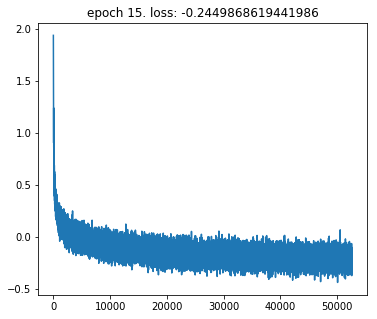

torch.Size([1, 67, 5]) torch.Size([1, 68, 5]) torch.Size([1, 68, 5])


KeyboardInterrupt: 

In [98]:
while epoch < num_epochs:
    for batch_per_epoch in range(len(data) // batch_size):
        batch, batch_in, batch_out, mask = data.get_batch(batch_size)
        batch, batch_in, batch_out, mask = (batch.to(device), 
                                            batch_in.to(device), 
                                            batch_out.to(device), 
                                            mask.to(device))
        if conditional:
            loss = model(batch, batch_in, batch_out, mask)
        else:
            loss = model(batch_in, batch_out, mask)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        
        if batch_per_epoch % 500 == 0:
            plot(epoch, losses)
            draw(idx)
            
        idx += 1
        
        if epoch % 5 ==0 and epoch != 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * lr_decay
        
    epoch += 1

<h2>HomeWork</h2>

<p>1. Добавьте learning decay для лучшей сходимости [1 бал]</p>
<p>2. Натреньте сетку на других датасетах google sketchs [5 балов]</p>
<p>3. Сделайте рефакторинг кода модели [3 бала]</p>
<p>4. Натренируйте Unconditional Decoder на нескольких объеденных датасетах. Покажите какие рисунки генерит сеть при разной темпретуре [10 балов]</p>
<p><b>Bonus:</b> Сделайте "AR" рисовалку. Можно применить edge detection для фото и дорисовывать скетчи [30 балов]</p>
<img src="https://i.imgur.com/tkYiWlf.png" >

### 1. Добавьте learning decay для лучшей сходимости [1 бал]
 Done!


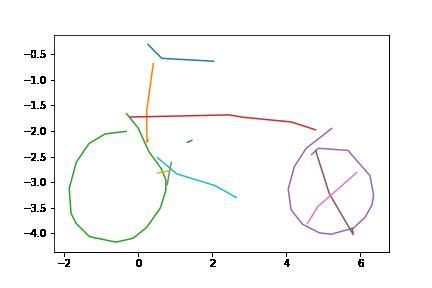

In [99]:
### 2. Натреньте сетку на других датасетах google sketchs [5 балов]
#bicycle dataset
from IPython.display import Image
Image(filename='Images/image_56524.jpg')

4. Натренируйте Unconditional Decoder на нескольких объеденных датасетах. Покажите какие рисунки генерит сеть при разной темпретуре [10 балов]

In [102]:
class UnconditionalModel(nn.Module):
    def __init__(self, z_size):
        super(UnconditionalModel, self).__init__()
        self.z_size = z_size
        
    def forward(self, batch_in, batch_out, mask):
        
        #инициализируем нулями как написано в пейпере
        z = torch.zeros(batch_in.size(0), self.z_size).to(batch_in.device)
        dec_input = torch.cat([batch_in, z.unsqueeze(1).repeat(1, batch_in.size(1), 1)], -1)
        weight, mean_x, mean_y, std_x, std_y, rho_xy, pen_probs, _ = self.decoder(dec_input, z)

        #gmm loss
        x = batch_out[:,:,0].unsqueeze(-1)
        y = batch_out[:,:,1].unsqueeze(-1)
        gmm_loss = compute_gmm_loss(x, y, mean_x, mean_y, std_x, std_y, rho_xy, weight, mask)
        
        #cross entropy loss
        pen_target = batch_out[:,:,2:]
        pen_loss   = compute_pen_loss(pen_target, pen_probs)

        loss = gmm_loss + pen_loss
        
        return loss

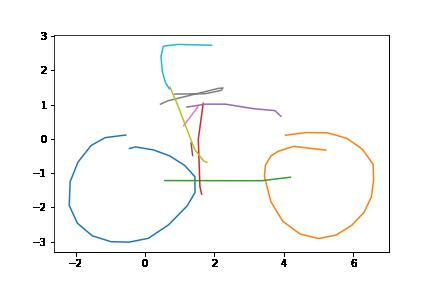

In [101]:
#Результат unconditional model
Image(filename='Images/uncond/image_51146.jpg')